In [1]:
from copy import deepcopy
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pathlib as pl
import torchvision
import random
from PIL import Image
import random
torch.backends.cudnn.benchmark = True # makes code faster through optimization of code
torch.set_printoptions(precision=6)
from joblib import Parallel, delayed
from __crossval_dataloader_for_inference import Dataset
random.seed(0)
rand_state = 0
torch.manual_seed(0)
import json
import tifffile
import cv2

# Get path to a WSI
#### In this example, using MASI lab paths, it is:
#### 1) Virtual H&E
#### 2) in OME tiff format, and so we will read it as such.

In [2]:
wsi_dir = pl.Path("/nfs/masi/remedilw/paper_journal_nucleus_subclassification/nucleus_subclassification/example_data/wsi_vhe")

wsi_path = [x for x in wsi_dir.iterdir()]

assert len(wsi_path) == 1

wsi_path = wsi_path[0]


# Get path to corresponding nucleus instance segmentation
#### These predictions are the direct output of a hovernet that was trained for only instance segmentation (no classification) on virtual H&E whole slide images.
#### The predictions were reproduced using the linked customized hovernet github repo here: https://github.com/MASILab/hovernets_on_vhe 
#### But to keep things separate, the outputs have been copied to another location on the MASI systems to be used as input to this example (just to keep things clean)


In [3]:
hovernet_predicted_nuc_coordinates_dir = pl.Path("/nfs/masi/remedilw/paper_journal_nucleus_subclassification/nucleus_subclassification/example_data/example_output/json")

hovernet_predicted_nuc_coordinates = [x for x in hovernet_predicted_nuc_coordinates_dir.iterdir()]
assert len(hovernet_predicted_nuc_coordinates) == 1
hovernet_predicted_nuc_coordinates = hovernet_predicted_nuc_coordinates[0]


### Verify the example matches between the image and predicted segmentation

In [4]:
hovernet_predicted_nuc_coordinates.stem == wsi_path.stem

True

# Load the hovernet JSON file of nucleus coordinates, and convert to a dataframe

In [5]:
with open(hovernet_predicted_nuc_coordinates, 'r') as json_file:
    hn_pred = json.load(json_file)

df = pd.DataFrame.from_dict(hn_pred["nuc"] ).T

# remove columns that are not relevant because we didn't train hovernets to classify nuclei
df = df.drop(['type_prob', 'type'], axis=1)

In [6]:
# convert the string literal coordinates to list of floats
# df["centroid"] = df["centroid"].apply(lambda x: ast.literal_eval(x))

# split the coordinates into integers for row and column
df['centroid_row'] = df['centroid'].apply(lambda x: int(x[1]) )
df['centroid_col'] = df['centroid'].apply(lambda x: int(x[0]) )

# add path to out vH&E image
df["vhe"] = str(wsi_path)


#make sure the dataframe index is int
df.index = df.index.astype(int)


### in this example, IDs for each nuclei have not been defined
- So we just use the index from the predicted identifier from the hovernet.
- This may be inappropriate for your use case 

In [7]:
df["ID"] = df.index

### clean up the dataframe index 

In [8]:
df.index = range(len(df))

In [9]:
df.index

RangeIndex(start=0, stop=11290, step=1)

# Set patch size and pick weights 

In [10]:
# the actual patch size we will use. 
# don't need to resample because the virtual H&E we are looking at has already been resmapled to 0.5 mpp
patch_size = 41 
trained_weights = pl.Path("/nfs/masi/remedilw/paper_journal_nucleus_subclassification/nucleus_subclassification/weights/fold_0_weights.pth")


device_idx = 0

input_channels = 3
output_classes = 14


# 13 cells. We dropped leukocyte because it didn't make sense in the tree
mapping_level_2 = {

    0 : "Leukocyte",

    1: 'B',
    2: 'T_Receptor',
    3: 'T_Helper',
    4: 'Cytotoxic_T',


    5: 'Myeloid',
    6: 'Monocytes',
    7: 'Macrophages',

    8: 'Enterocyte',
    9: 'Epithelial Progenitor',
    10: 'Enteroendocrine',
    11: 'Goblet cell',

    12: 'Fibroblasts',
    13: 'Stromal (Undetermined)',
}



reverse_mapping_level_2 = {v:k for k,v in mapping_level_2.items()}




### we will classify the ~11 thousand predicted nuclei on this whole slide image of virtual H&E

In [11]:
# n_val_items = len(test_df)
n_val_items = len(df)

n_val_items


11290

### Check GPU 

In [12]:
print( "Is cuda available?:", torch.cuda.is_available() )

print( "How many gpus are available?", torch.cuda.device_count() )

#print( torch.cuda.current_device() )

#print( torch.cuda.device(     ) )

print( "Name of my specificed GPU:", torch.cuda.get_device_name(device_idx) )
#--------------------------------------------------------------------------------




device = torch.device("cuda:{}".format(device_idx))



Is cuda available?: True
How many gpus are available? 2
Name of my specificed GPU: RTX A6000


### Load Model and use pretrained weifghts 

In [13]:
#--------------------------------------------------------------------------------
### Model
# #--------------------------------------------------------------------------------

model = torchvision.models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")

# change input channels to match image dimensions
model.conv1 = torch.nn.Conv2d(input_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model.bn1 = torch.nn.InstanceNorm2d(64, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer1[0].bn1 = torch.nn.InstanceNorm2d(64, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer1[0].bn2 = torch.nn.InstanceNorm2d(64, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer1[1].bn1 = torch.nn.InstanceNorm2d(64, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer1[1].bn2 = torch.nn.InstanceNorm2d(64, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)



model.layer2[0].bn1 = torch.nn.InstanceNorm2d(128, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer2[0].bn2 = torch.nn.InstanceNorm2d(128, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer2[0].downsample[1] = torch.nn.InstanceNorm2d(128, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)


model.layer2[1].bn1 = torch.nn.InstanceNorm2d(128, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer2[1].bn2 = torch.nn.InstanceNorm2d(128, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)




model.layer3[0].bn1 = torch.nn.InstanceNorm2d(256, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer3[0].bn2 = torch.nn.InstanceNorm2d(256, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer3[0].downsample[1] = torch.nn.InstanceNorm2d(256, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)


model.layer3[1].bn1 = torch.nn.InstanceNorm2d(256, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer3[1].bn2 = torch.nn.InstanceNorm2d(256, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)



model.layer4[0].bn1 = torch.nn.InstanceNorm2d(512, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer4[0].bn2 = torch.nn.InstanceNorm2d(512, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer4[0].downsample[1] = torch.nn.InstanceNorm2d(512, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)


model.layer4[1].bn1 = torch.nn.InstanceNorm2d(512, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)

model.layer4[1].bn2 = torch.nn.InstanceNorm2d(512, 
                                    eps=1e-05, 
                                    momentum=0.1,
                                    affine=False, 
                                    track_running_stats=False)



model.fc = torch.nn.Linear(in_features=512, out_features=output_classes, bias=True)




# model = ResNet18(input_channels, output_classes)

model = model.to(device)

# Load pretrained weights

In [14]:
model.load_state_dict( torch.load(  trained_weights  ))


<All keys matched successfully>

# Make a dataloader for easy inference 

In [15]:
########################################################
# Dataloader

val_ds = Dataset(dataframe=df, 
                n_items=n_val_items, 
                mapping_level_2=mapping_level_2, 
                reverse_mapping_level_2=reverse_mapping_level_2,
                mapping_level_1=None, # passing nothign because this is not used
                reverse_mapping_level_1=None, # passing nothign because this is not used
                mapping_level_0=None,  # passing nothign because this is not used
                reverse_mapping_level_0=None, # passing nothign because this is not used
                patch_size=patch_size,
                training=False,
                )


val_gen = torch.utils.data.DataLoader(
                    val_ds,
                    batch_size=64, # fine because the training used instance norm
                    shuffle=False, # validation
                    pin_memory=True,
                    num_workers=3,
                    # prefetch_factor=5
            )



# Predict the class of the nuclei

In [16]:
# Make predictions


pred_df = pd.DataFrame()
pred_df["pred_2"] = np.nan 
pred_df["ID"] = np.nan




# run validation
model.eval()

with torch.no_grad():

    for i, (img_cpu, cur_id) in enumerate(val_gen):



        with torch.cuda.amp.autocast():

            img = img_cpu.to(device)
            # label_2 = label_2_cpu.to(device)
            # label_1 = label_1_cpu.to(device)
            # label_0 = label_0_cpu.to(device)


            pred = model(img)

            class_pred_2 = torch.argmax( pred, dim=1 )


            p_and_l = pd.DataFrame()
            p_and_l["pred"] = pd.DataFrame(class_pred_2.detach().cpu())


            p_and_l["ID"] = pd.DataFrame(cur_id.detach().cpu())

            
            pred_df = pd.concat([pred_df, p_and_l], axis=0)


In [17]:
pred_df.columns

Index(['pred_2', 'ID', 'pred'], dtype='object')

# Integrate the predicted classes back into the hovernet style JSON format

In [18]:

def mapping_func_2(integ):

    return mapping_level_2[integ]



pred_df["Pred_String"] = pred_df["pred"].map(mapping_func_2)



# rejoin the test dataframe with the 
merged = df.merge( pred_df, on="ID", how="left" )


# change index to the cell identifier
merged.index = merged["ID"]

# cast to string because that is the expected format
merged.index = merged.index.astype(str)


# put the dataframe into a dictionary format
result_dict = dict()

for i, row in merged.iterrows():

    # Initialize a dictionary for each row
    row_dict = dict()
    
    # Iterate over the DataFrame columns
    for column, value in row.items():
        row_dict[column] = value
    
    # Add the row dictionary to the result using the index as the key
    result_dict[i] = row_dict


result_dict = {

    "mag" : np.nan,
    "nuc" : result_dict

}


# The variable named result_dict could be saved as JSON.
- This is like the hovernet jon, but with the new cell classifications for 14 classes

# Show some qualitative results to see that this makes sense 

In [19]:
with tifffile.TiffFile( wsi_path ) as tif:
    wsi = tif.asarray()


In [20]:
wsi.shape

(6769, 6348, 3)

In [21]:

width = int( wsi.shape[1] )
height = int( wsi.shape[0] )


empty = np.zeros( (height+256, width+256, 3), dtype=np.uint8  )

marker_size = 5
for i, row in merged.iterrows():

    r = row["centroid_row"]
    c = row["centroid_col"]
    
    if row["Pred_String"] == "Leukocyte":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [230, 190, 255]


    elif row["Pred_String"] == "B":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [250, 190, 190]


    elif row["Pred_String"] == "T_Receptor":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [255, 225, 25]


    elif row["Pred_String"] == "T_Helper":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [240, 50, 230]

    elif row["Pred_String"] == "Cytotoxic_T":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [67, 99, 216]

    elif row["Pred_String"] == "Myeloid":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [145, 30, 180]

    elif row["Pred_String"] == "Monocytes":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [255, 250, 200]


    elif row["Pred_String"] == "Macrophages":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [188, 246, 12]

    elif row["Pred_String"] == "Enterocyte":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [230, 25, 75]

    elif row["Pred_String"] == "Epithelial Progenitor":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [245, 130, 49]

    elif row["Pred_String"] == "Enteroendocrine":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [0, 128, 128]

    elif row["Pred_String"] == "Goblet cell":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [60, 180, 75]

    elif row["Pred_String"] == "Fibroblasts":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [154, 99, 36]
    
    elif row["Pred_String"] == "Stromal (Undetermined)":
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [70, 240, 240]

    else:
        print("NOT DEFINED", row["Pred_String"])


### WSI with 14 class predictions 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


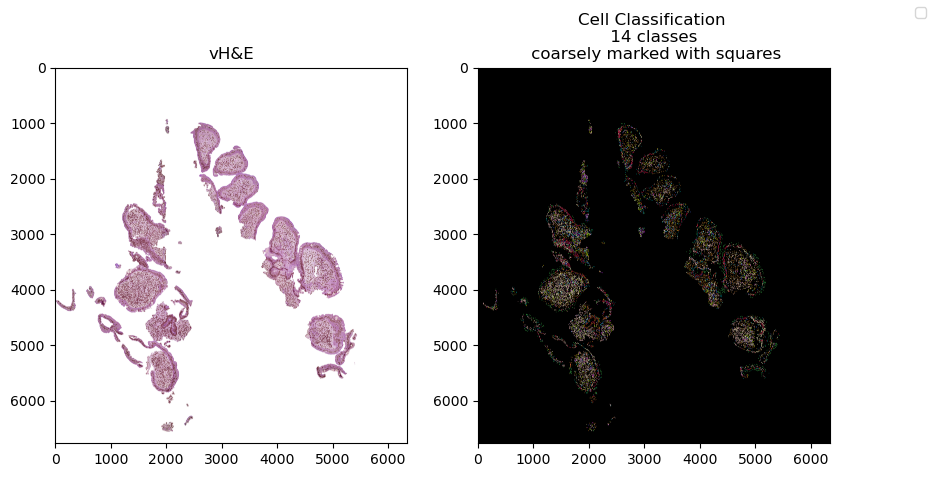

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(wsi)
axs[1].imshow(empty[:wsi.shape[0], :wsi.shape[1]])

axs[0].set_title('vH&E')
axs[1].set_title('Cell Classification \n 14 classes \n coarsely marked with squares')

fig.legend()

### Zoom in

Text(0.5, 1.0, 'Cell Classification \n 14 classes \n coarsely marked with squares')

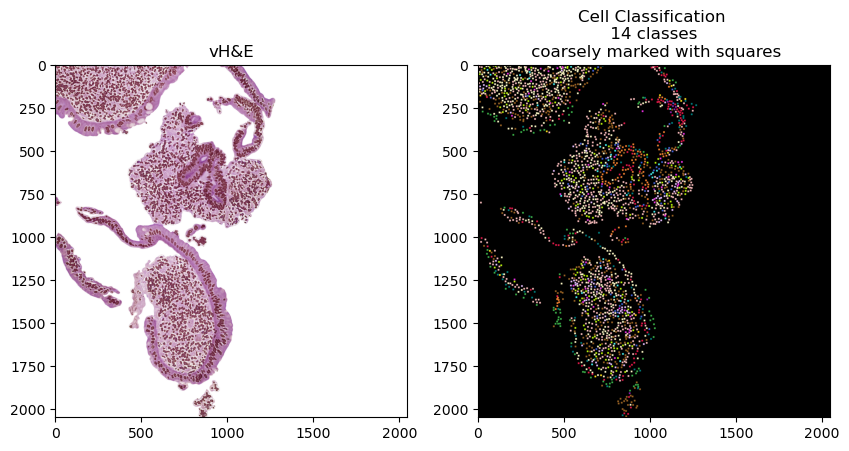

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(wsi[4000:6048, 1200:3248])
axs[1].imshow(empty[4000:6048, 1200:3248])


axs[0].set_title('vH&E')
axs[1].set_title('Cell Classification \n 14 classes \n coarsely marked with squares')

# plt.legend()

### Simplified clases into 3 groups, rather than 14

In [24]:
merged["Pred_String"].unique()

array(['B', 'Fibroblasts', 'Enteroendocrine', 'Macrophages', 'T_Receptor',
       'Myeloid', 'Leukocyte', 'Stromal (Undetermined)', 'Enterocyte',
       'Cytotoxic_T', 'Monocytes', 'Epithelial Progenitor', 'Goblet cell',
       'T_Helper'], dtype=object)

In [25]:

width = int( wsi.shape[1] )
height = int( wsi.shape[0] )


empty = np.zeros( (height+256, width+256, 3), dtype=np.uint8  )

marker_size = 5
for i, row in merged.iterrows():

    r = row["centroid_row"]
    c = row["centroid_col"]
    
    # epithelium to green
    if row["Pred_String"] == "Epithelial Progenitor" or row["Pred_String"] == "Enterocyte" or row["Pred_String"] == "Goblet cell" or row["Pred_String"] == "Enteroendocrine" :
        
        
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [0, 255, 0]

    # connective to blue
    elif row["Pred_String"] == "Stromal (Undetermined)" or row["Pred_String"] == "Fibroblasts":
        
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [0, 130, 200]

    # immune to red
    else:
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [230, 25, 75]




In [26]:
empty.shape

(7025, 6604, 3)

In [27]:
wsi.shape

(6769, 6348, 3)

Text(0.5, 1.0, 'Cell Classification \n Overlay')

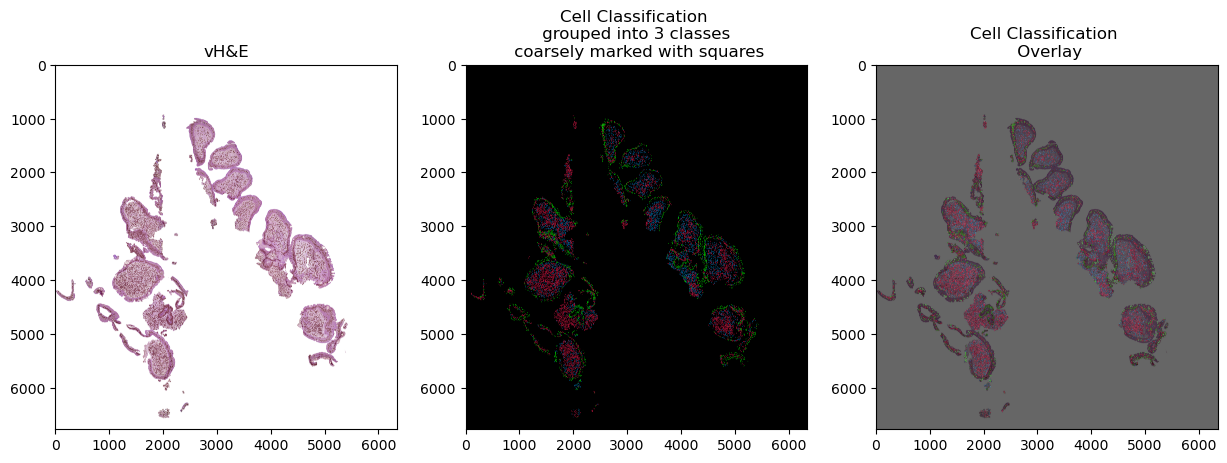

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(wsi)
axs[1].imshow(empty[:wsi.shape[0], :wsi.shape[1]])
axs[2].imshow(wsi)
axs[2].imshow(empty[:wsi.shape[0], :wsi.shape[1]], alpha=0.6)

axs[0].set_title('vH&E')
axs[1].set_title('Cell Classification \n grouped into 3 classes \n coarsely marked with squares')
axs[2].set_title('Cell Classification \n Overlay')


Text(0.5, 1.0, 'Cell Classification \n Overlay')

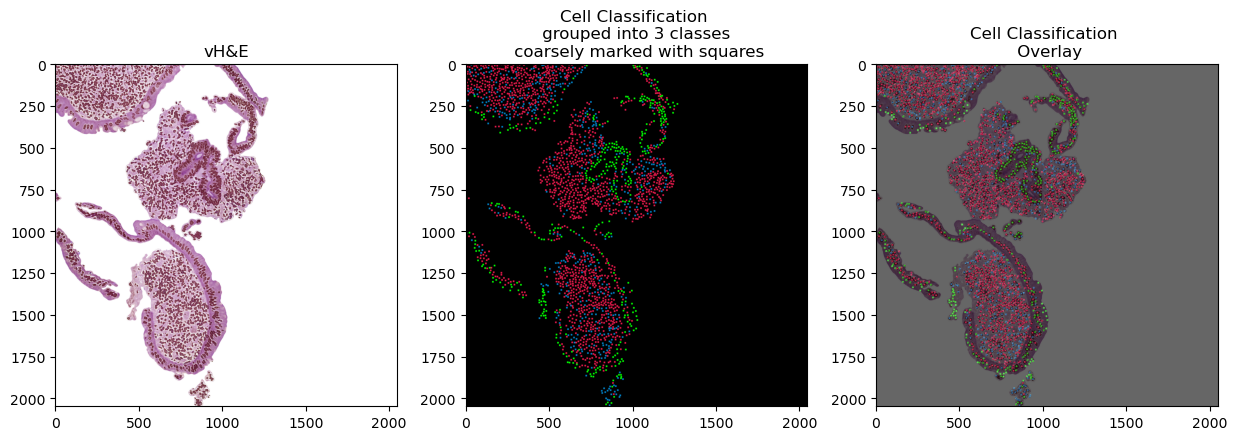

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(wsi[4000:6048, 1200:3248])
axs[1].imshow(empty[4000:6048, 1200:3248])
axs[2].imshow(wsi[4000:6048, 1200:3248])
axs[2].imshow(empty[4000:6048, 1200:3248], alpha=0.6)

axs[0].set_title('vH&E')
axs[1].set_title('Cell Classification \n grouped into 3 classes \n coarsely marked with squares')
axs[2].set_title('Cell Classification \n Overlay')


### smaller marker for zoom

In [30]:

width = int( wsi.shape[1] )
height = int( wsi.shape[0] )


empty = np.zeros( (height+256, width+256, 3), dtype=np.uint8  )

marker_size = 2
for i, row in merged.iterrows():

    r = row["centroid_row"]
    c = row["centroid_col"]
    
    # epithelium to green
    if row["Pred_String"] == "Epithelial Progenitor" or row["Pred_String"] == "Enterocyte" or row["Pred_String"] == "Goblet cell" or row["Pred_String"] == "Enteroendocrine" :
        
        
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [0, 255, 0]

    # connective to blue
    elif row["Pred_String"] == "Stromal (Undetermined)" or row["Pred_String"] == "Fibroblasts":
        
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [0, 130, 200]

    # immune to red
    else:
        empty[ r-marker_size:r+marker_size, c-marker_size:c+marker_size  ] = [230, 25, 75]





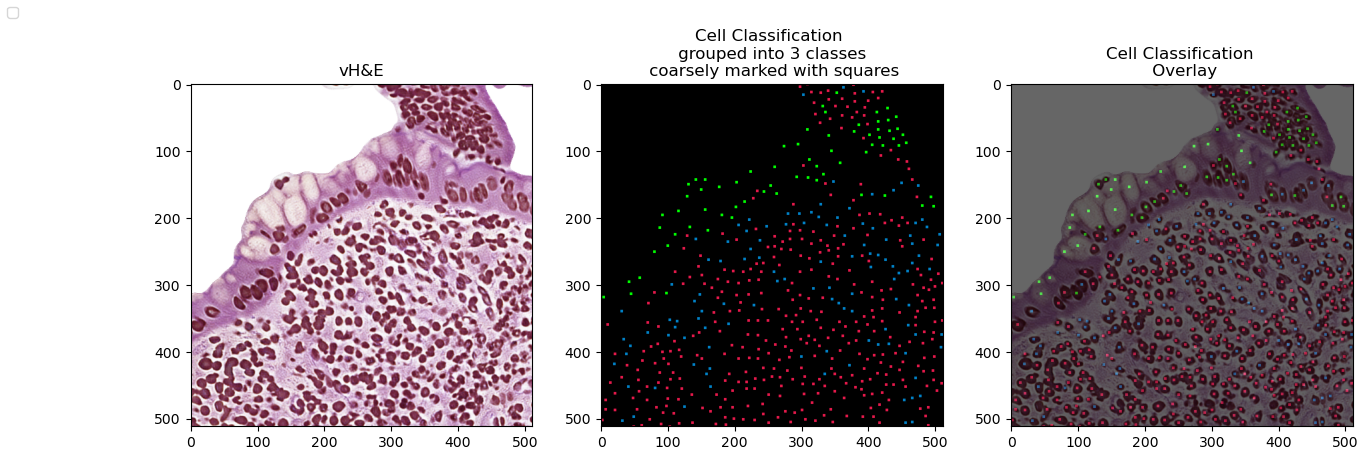

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

__size = 512

start_row = 3500
stop_row = start_row + __size

start_col = 1200
stop_col = start_col + __size

axs[0].imshow(wsi[start_row:stop_row, start_col:stop_col])
axs[1].imshow(empty[start_row:stop_row, start_col:stop_col])
axs[2].imshow(wsi[start_row:stop_row, start_col:stop_col])
axs[2].imshow(empty[start_row:stop_row, start_col:stop_col], alpha=0.6)


axs[0].set_title('vH&E')
axs[1].set_title('Cell Classification \n grouped into 3 classes \n coarsely marked with squares')
axs[2].set_title('Cell Classification \n Overlay')
fig.legend(['Square', 'Linear'], loc='upper left') 